# Analysis of programming language usage and popularity from StackOverflow Developer Survey 2020 data

## Ingest and prepare data

### Import necessary libraries and read the data

In [1]:
import pandas as pd
%config Completer.use_jedi = False

In [2]:
df = pd.read_csv('./survey_results_public.csv')
print(df.shape)

(64461, 61)


### Drop the rows for responders who haven't answered which language(s) they use

In [3]:
df = df.dropna(subset=["LanguageWorkedWith"])
print(df.shape)

(57378, 61)


## Language popularity

### Count and plot the relative popularity for each language

In [4]:
languages_worked_with_sums = df.LanguageWorkedWith.str.get_dummies(sep=';').sum()

In [5]:
pd.DataFrame((languages_worked_with_sums.sort_values(ascending=False) / len(df))).style.bar(color=["#83f2a8"])

,0
JavaScript,0.676601
HTML/CSS,0.630573
SQL,0.547475
Python,0.440709
Java,0.402140
Bash/Shell/PowerShell,0.330789
C#,0.314424
PHP,0.261546
TypeScript,0.254070
C++,0.238889


### How often do programmers desire to learn a particular language relative to the size of the current userbase

In [6]:
language_pop_trend = pd.DataFrame(((df.LanguageDesireNextYear.str.get_dummies(sep=';').sum() - df.LanguageWorkedWith.str.get_dummies(sep=';').sum())/languages_worked_with_sums).sort_values(ascending=False));
language_pop_trend.style.bar(align="mid", color=['#d65f5f', '#83f2a8'])

,0
Rust,2.594401
Julia,2.157996
Go,1.494244
Haskell,1.432897
Kotlin,1.133617
Dart,1.066228
Scala,0.675926
Swift,0.649985
R,0.287105
TypeScript,0.172932


## JobSatisfaction

### Analysis

In [7]:
df.dropna(subset=["JobSat"], inplace=True)

#satisfaction = {"Very dissatisfied" : 0, "Slightly dissatisfied": 0.25, "Neither satisfied nor dissatisfied": 0.5, "Slightly satisfied": 0.75, "Very satisfied": 1}
satisfaction = {"Very dissatisfied" : -2, "Slightly dissatisfied": -1, "Neither satisfied nor dissatisfied": 0, "Slightly satisfied": 1, "Very satisfied": 2}
y = df['JobSat'].map(satisfaction)

<AxesSubplot:>

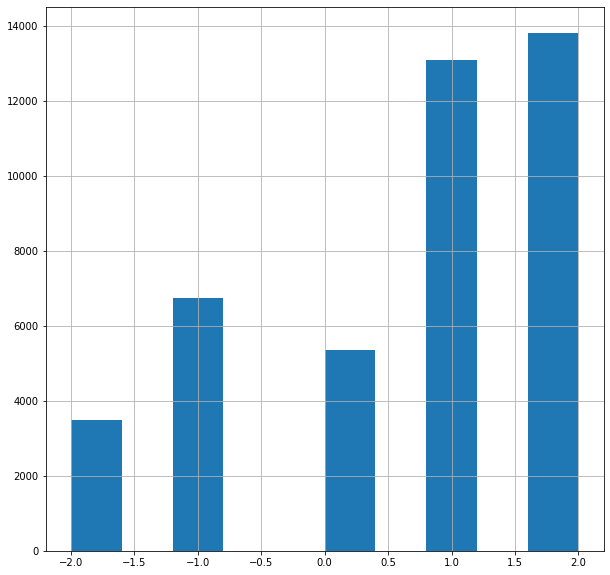

In [8]:
y.hist(figsize=(10,10))

In [9]:
programming_languages = df.LanguageWorkedWith.str.split(";").explode().unique()
# The original list contains a NaN, removed with a filter: https://stackoverflow.com/questions/11620914/removing-nan-values-from-an-array (udibr)
programming_languages = list(filter(lambda v: v==v, programming_languages))

In [10]:
X = df.LanguageWorkedWith.str.get_dummies(sep=';')

### +/- stats

If a certain language is mentioned by a person, the job satisfaction of this person is added for that language. The sum of all these is divided by the counts for each language. In a fashion of ice hockey +/- stats. If a certain player is on ice when their team scores a goal, they get a +1, if they are there when the team receives a goal, they get -1.

<AxesSubplot:>

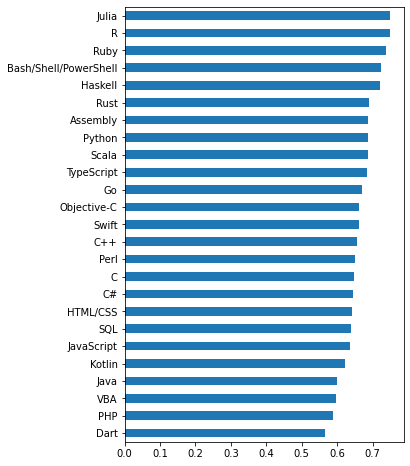

In [11]:
satdf = pd.DataFrame(
    ([(X[p] * y).sum() / X[p].sum()] for p in programming_languages), columns=["Satisfaction"], index=programming_languages
)

satdf.sort_values(by="Satisfaction", inplace=True)
satdf["Satisfaction"].plot.barh(figsize=(5,8))

### Predicting

#### Splitting the data to test and training sets

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Linear regression

In [13]:
from sklearn.linear_model import LinearRegression

lm_model = LinearRegression(normalize=True)
lm_model.fit(X_train, y_train)
lm_model.score(X_test, y_test)

0.006107798980839574

#### NN Classifier

In [14]:
from sklearn.neural_network import MLPClassifier

X_train, X_test, y_train, y_test = train_test_split(X, df["JobSat"], test_size = 0.5, random_state=42)

mlpc = MLPClassifier(max_iter=500)
mlpc.fit(X_train,y_train)
print(mlpc.classes_)
mlpc.score(X_test, y_test)

['Neither satisfied nor dissatisfied' 'Slightly dissatisfied'
 'Slightly satisfied' 'Very dissatisfied' 'Very satisfied']


0.3166831287333616

#### Random Tests

In [15]:
mlpc.predict_proba([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

array([[0.39856865, 0.08461029, 0.02380738, 0.20231192, 0.29070176]])

In [16]:
mlpc.predict([[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]])

array(['Neither satisfied nor dissatisfied'], dtype='<U34')

In [17]:
mlpc.predict([[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])

array(['Very satisfied'], dtype='<U34')

In [18]:
mlpc.predict([[1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,1]])

array(['Slightly satisfied'], dtype='<U34')

In [19]:
mlpc.predict(X_test)

array(['Very satisfied', 'Slightly dissatisfied', 'Slightly satisfied',
       ..., 'Slightly satisfied', 'Slightly satisfied', 'Very satisfied'],
      dtype='<U34')